# ch05. 텍스트 유사도
## 00. 텍스트 유사도 문제란?
- 텍스트 유사도(Text Similarity)
  - 두 문장(글)이 있을 때 문장 간 유사도를 측정하는 모델을 만드는 것

## 01. 실습 문제 소개

### 1) 실습 데이터

|||
|---|---|
|데이터 이름|Quora Question Pairs|
|데이터 용도|텍스트 유사도 학습 목적|
|데이터 권한|MIT 권한을 가지나 캐글 가입 후 사용 권장|
|데이터 출처|https://www.kaggle.com/c/quora-question-pairs/data  


- 쿼라(Quora)
  - 질문과 답변을 할 수 있는 사이트
  - 쿼라의 월 사용자는 대략 1억 명  
  → 중복 질문을 찾아 정리한다면 더 좋은 서비스 제공 가능



## 02. 데이터 분석과 전처리
### 1) 데이터 분석

- Anaconda Prompt를 이용해 캐글 데이터 받기

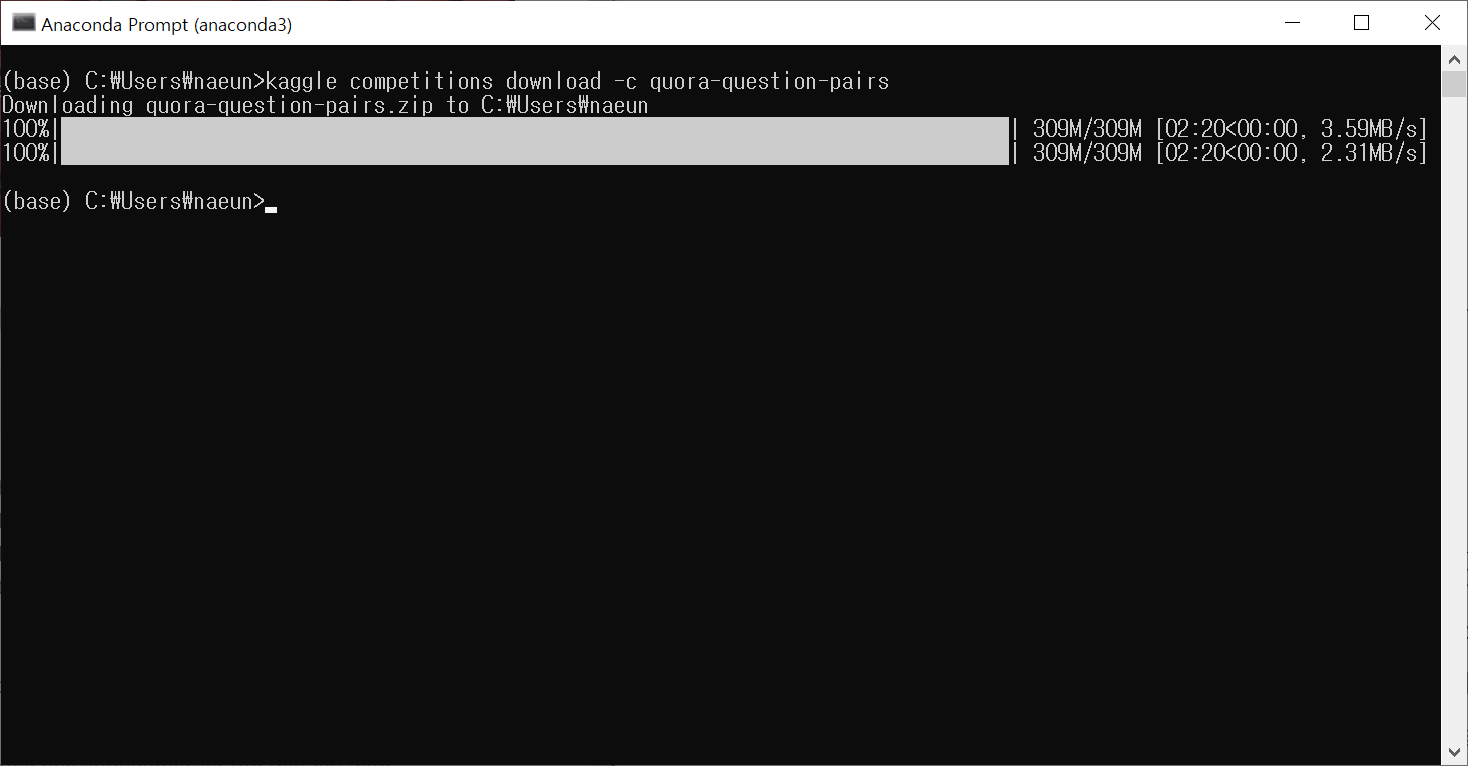

In [1]:
import zipfile

DATA_IN_PATH = './data/quora-question-pairs/'

file_list = ['train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']

for file in file_list:
    zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
    zipRef.extractall(DATA_IN_PATH)
    zipRef.close()

- 데이터셋 구성 확인
  - sample_submission.csv: 캐글 제출 시 맞춰야 하는 양식 틀
  - train.csv: 학습 데이터
  - test.csv: 평가 데이터  


- 패키지 라이브러리

In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

- 학습 데이터 불러오기

In [3]:
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


- 데이터 확인
  - 'id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'
  - id: 각 행 데이터의 고유 인덱스 값
  - qid1, qid2: 각 질문의 고유 인덱스 값
  - question1, question2: 각 질문의 내용
  - is_duplicate: 0(두 개 질문이 중복 아님), 1(두 개 질문이 중복)
  
  
- 파일 크기 확인

In [4]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file and 'zip' not in file: # csv가 들어가고 zip이 들어가지 않는 파일만 확인
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
sample_submission.csv         22.35MB
test.csv                      477.59MB
train.csv                     63.4MB


- 확인 결과
  - 평가 데이터가 훈련 데이터보다 5배 이상 큼  
    → 쿼라의 경우, 질문에 대해 데이터 수가 적으면 검색하여 중복을 찾는 편법을 사용할 수 있기 때문에 이를 방지하기 위해 직접 컴퓨터가 만든 질문 쌍을 평가 데이터에 임의로 추가  
    → 평가 데이터가 크지만, 실제 질문 데이터는 얼마 되지 않으며 캐글에 제출할 때 컴퓨터가 만든 질문쌍에 관한 예측은 점수에 포함되지 않음  
    

- 학습데이터 수 확인

In [5]:
print('전체 학습데이터 수: {}'.format(len(train_data)))

전체 학습데이터 수: 404290


- 중간 확인
  - 판다스는 데이터프레임(행렬 구조), 시리즈(인덱스를 가짐) 자료 구조를 가짐
  - 현재 데이터는 하나의 데이터에 두 개의 질문이 있는 구조
  - 전체 질문(2가지 질문)을 한 번에 분석하기 위해 판다스 시리즈로 두 개의 질문 합치기
  

- 다음 작업
   1. 질문 중복 분석
   2. 라벨 빈도 분석
   3. 문자 분석
   4. 단어 분석
   

#### ① 질문 중복 분석

In [6]:
train_set = pd.Series(train_data['question1'].tolist() + #tolist(): 배열을 목록으로 변환(list)
                      train_data['question2'].tolist()).astype(str) #astype(str): string으로 변환
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [7]:
# 넘파이의 unique 함수로 중복 제거하고 유일한 질문값만 확인하기
print('train_set 총 질문 수: {}'.format(len(np.unique(train_set))))

# 중복되는 질문 개수 확인을 위해 value_counts가 2 이상인 값의 개수를 더함
print('반복되어 나타나는 질문 수: {}'.format(np.sum(train_set.value_counts() > 1)))

train_set 총 질문 수: 537361
반복되어 나타나는 질문 수: 111873


- 질문 중복 분석 결과
  - 약 80만 개 데이터 중, 약 53만 개가 고유 데이터, 약 27만 개가 중복된 데이터
  - 약 27만 개 중복 데이터는 11만 개의 고유한 질문으로 이루어짐


- 맷플롯립을 통한 시각화
  - 히스토그램은 'question'값 개수를 보여줌

Text(0, 0.5, 'Number of questions')

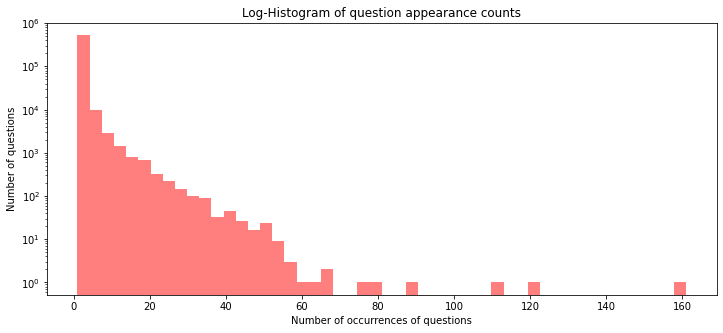

In [8]:
# 그래프 이미지 사이즈
# figsize: (가로, 세로) 형태 튜플
plt.figure(figsize=(12, 5))

# 히스토그램
# bins: 히스토그램 값들에 대한 버켓 범위 / # range: x축 값의 범위
# alpha: 그래프 색상 투명도 / # color: 그래프 색상 / # label: 그래프에 대한 라벨

plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts') #그래프 제목
plt.xlabel('Number of occurrences of questions') #그래프 x 축 라벨
plt.ylabel('Number of questions') #그래프 y 축 라벨

In [9]:
# 통계치로 확인
print('최대 중복 개수: {}'.format(np.max(train_set.value_counts())))
print('최소 중복 개수: {}'.format(np.min(train_set.value_counts())))
print('평균 중복 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))

# 사분위의 대한 경우는 0~100 스케일로 되어 있음
print('제1사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제3사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

최대 중복 개수: 161
최소 중복 개수: 1
평균 중복 개수: 1.50
중복 표준편차: 1.91
중복 중간길이: 1.0
제1사분위 중복: 1.0
제3사분위 중복: 1.0


- 통계치 확인
  - 중복 발생 횟수 평균이 1.5인 것은 많은 데이터가 최소 1개 이상 중복됨을 의미

{'whiskers': [<matplotlib.lines.Line2D at 0x1fa75a7b070>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa75a7b730>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa75a30cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fa75a7be20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fa75a824c0>],
 'means': [<matplotlib.lines.Line2D at 0x1fa75a82160>]}

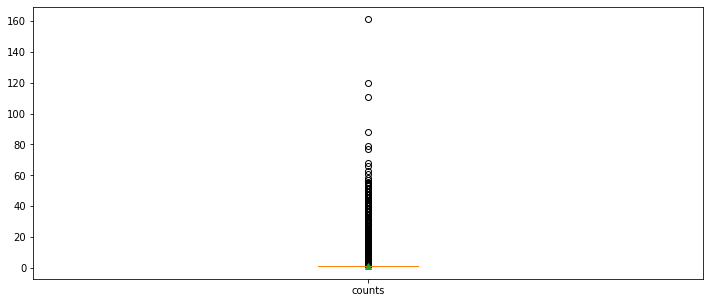

In [10]:
# 박스플롯으로 확인
plt.figure(figsize=(12, 5))

# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨 / # showmeans: 평균값을 마크함
plt.boxplot([train_set.value_counts()],
             labels=['counts'],
             showmeans=True)

- 박스플롯 결과
  - 중복 횟수의 이상치(outliers)가 너무 넓고 많이 분포하여 박스 플롯 다른 값 확인이 어려움
  
  
- 다음 단계: **워드클라우드**
  - 데이터에 어떤 단어가 포함되었는지 살펴보기

(-0.5, 799.5, 599.5, -0.5)

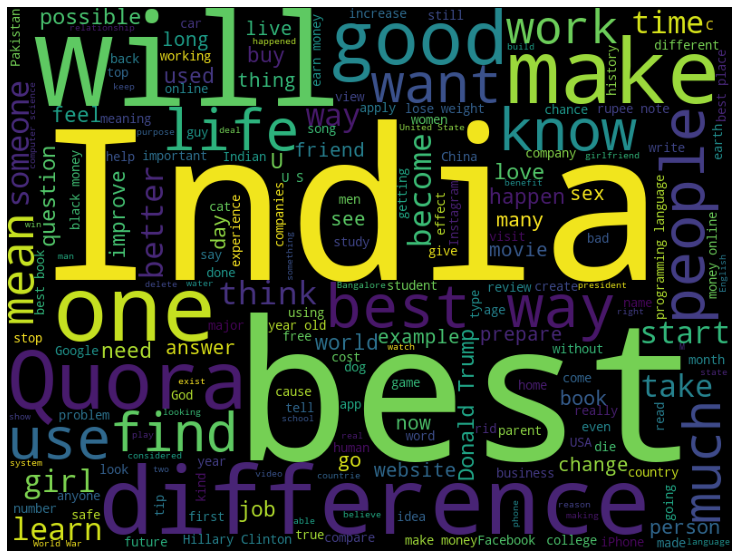

In [11]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

- 워드클라우드 확인
  - Donald Trump가 존재하는 이유는 선거 기간 중 학습데이터가 만들어져서로 해석
  

#### ② 라벨 빈도 분석
- 라벨: 질문 중복을 나타내는 1, 질문 중복 아님을 나타내는 0

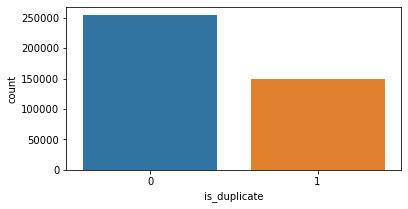

In [12]:
## 라벨 개수 파악하기
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['is_duplicate'])

- 라벨값 개수 확인
  - 약 40만 개 데이터
  - 중복 아닌 데이터 약 25만 개
  - 중복 데이터 약 15만 개
→ 중복 아닌 데이터 25만 개에 의존도가 높아지면서 데이터가 한쪽 라벨로 편향될 수 있음  
→ 라벨의 개수를 균형 있게 맞춰준 후 진행 필요


#### ③ 문자 분석
- 텍스트 길이 분석
  - 문자 단위로 길이 분석 후, 단어 단위로 길이 분석

Text(0, 0.5, 'Probability')

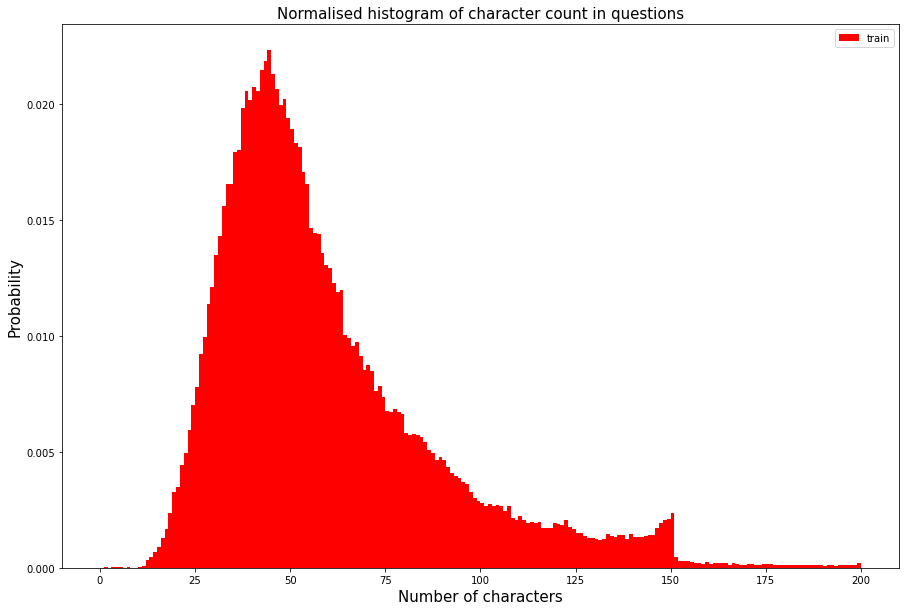

In [13]:
## 문자 단위 단어 분석
train_length = train_set.apply(len)

## 히스토그램 생성
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Normalised histogram of character count in questions", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

- 히스토그램 해석
  - 150자 길이 제한이 있다고 해석할 수 있음
  - 150자 넘는 데이터가 많지 않아 큰 문제가 되지 않음

In [14]:
## 통계치 확인
print('질문 길이 최댓값: {}'.format(np.max(train_length)))
print('질문 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('질문 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('질문 길이 중간값: {}'.format(np.median(train_length)))
print('질문 길이 제1사분위: {}'.format(np.percentile(train_length, 25)))
print('질문 길이 제3사분위: {}'.format(np.percentile(train_length, 75)))

질문 길이 최댓값: 1169
질문 길이 평균값: 59.82
질문 길이 표준편차: 31.96
질문 길이 중간값: 51.0
질문 길이 제1사분위: 39.0
질문 길이 제3사분위: 72.0


- 통계치 해석
  - 최댓값은 1169로 평균, 중간값과 매우 큰 차이를 보임
  - 제거하고 학습하는 것이 좋음

{'whiskers': [<matplotlib.lines.Line2D at 0x1fa78564ca0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa7855f3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa78564940>],
 'medians': [<matplotlib.lines.Line2D at 0x1fa7855fa60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fa7854f100>],
 'means': [<matplotlib.lines.Line2D at 0x1fa7855fd60>]}

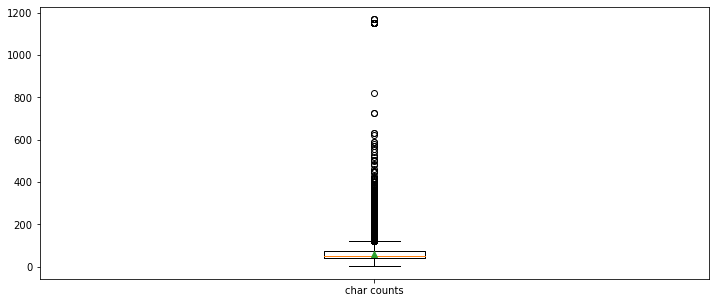

In [15]:
## 박스 플롯 그래프 확인

plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

- 박스플롯 해석
  - 문자 수 이상치 데이터가 많아, 박스플롯 다른 값을 확인하기 어려움
  
  
#### ④ 단어 분석

Text(0, 0.5, 'Prabability')

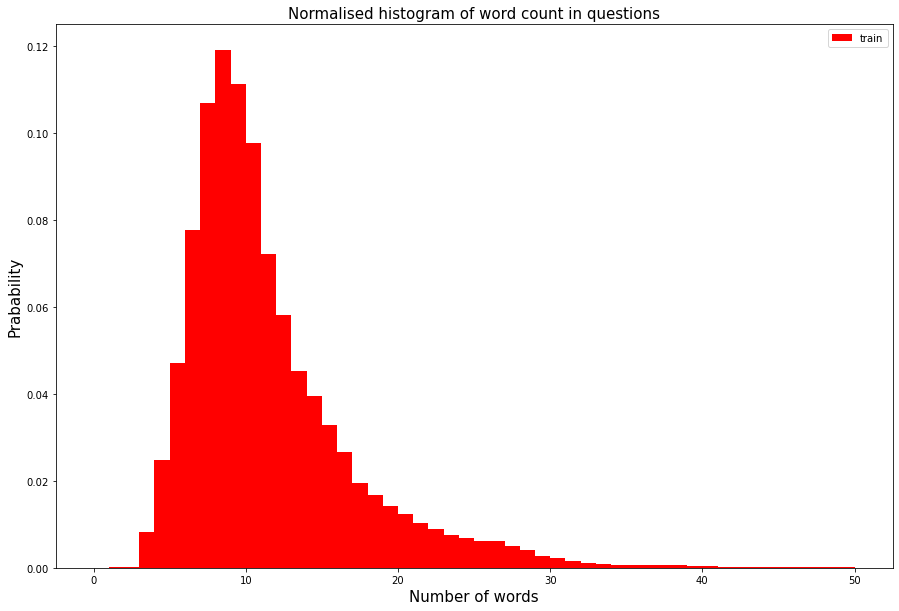

In [16]:
## 각 데이터에 단어 개수를 담은 변수 정의
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

## 히스토그램 작성
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [17]:
## 통계치 확인
print('질문 단어 개수 최댓값: {}'.format(np.max(train_word_counts)))
print('질문 단어 개수 평균값: {:.2f}'.format(np.mean(train_word_counts)))
print('질문 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('질문 단어 개수 중간값: {}'.format(np.median(train_word_counts)))
print('질문 단어 개수 제1사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('질문 단어 개수 제3사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('질문 단어 개수 99%: {}'.format(np.percentile(train_word_counts, 99)))

질문 단어 개수 최댓값: 237
질문 단어 개수 평균값: 11.06
질문 단어 개수 표준편차: 5.89
질문 단어 개수 중간값: 10.0
질문 단어 개수 제1사분위: 7.0
질문 단어 개수 제3사분위: 13.0
질문 단어 개수 99%: 31.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1fa2eab2e50>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa2eabd550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa2eab2af0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fa2eabdc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fa2eac42b0>],
 'means': [<matplotlib.lines.Line2D at 0x1fa2eabdf10>]}

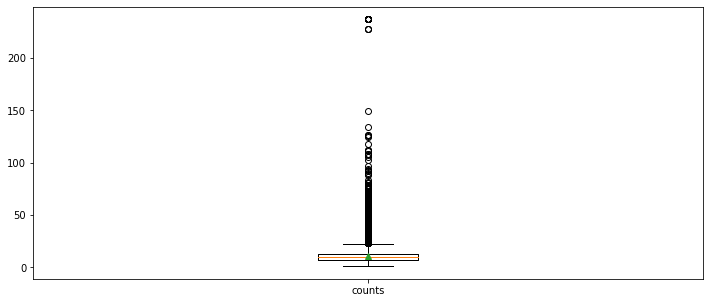

In [18]:
## 박스 플롯 생성
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

- 박스 플롯 해석
  - 이상치가 넓고 많이 분포됨을 확인


#### ⑤ 추가. 특정 경우 비율 확인해보기

In [19]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개
                  
print('물음표 있는 질문: {:.2f}%'.format(qmarks * 100))
print('수학 태그 있는 질문: {:.2f}%'.format(math * 100))
print('마침표 포함 질문: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자인 질문: {:.2f}%'.format(capital_first * 100))
print('대문자 있는 질문: {:.2f}%'.format(capitals * 100))
print('숫자 있는 질문: {:.2f}%'.format(numbers * 100))

물음표 있는 질문: 99.87%
수학 태그 있는 질문: 0.12%
마침표 포함 질문: 6.31%
첫 글자가 대문자인 질문: 99.81%
대문자 있는 질문: 99.95%
숫자 있는 질문: 11.83%


- 결과 확인
  - 대문자가 첫 글자인 질문과, 물음표를 동반하는 질문이 99% 이상 차지  
  → 모든 질문이 보편적으로 가지는 이 특성을 유지할 것인가? 해당 교재에서는 제거
  

### 2) 데이터 전처리

In [20]:
## 전처리 라이브러리 불러오기
import pandas as pd
import numpy as np
import re
import json

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [21]:
DATA_IN_PATH = './data/quora-question-pairs/'
FILTERS = "([~.,!?\"':;)(])"
MAX_SEQUENCE_LENGTH = 31

change_filter = re.compile(FILTERS)

train_data = pd.read_csv(DATA_IN_PATH + 'train.csv', encoding='utf-8')

#### ① 라벨 개수 균형 맞추기
- 중복이 아닌 데이터 개수가 더 많기 때문에, 데이터 개수를 줄인 후 분석 진행
  - 중복인 경우와 아닌 경우로 데이터를 나누고 중복이 아닌 개수가 비슷하도록 데이터의 일부 뽑기
  - 데이터프레임 객체의 loc 기능: 라벨이 1인 경우와 0인 경우를 분리하여 변수 생성

In [22]:
train_pos_data = train_data.loc[train_data['is_duplicate'] == 1]
train_neg_data = train_data.loc[train_data['is_duplicate'] == 0]

class_difference = len(train_neg_data) - len(train_pos_data)
sample_frac = 1 - (class_difference / len(train_neg_data))

train_neg_data = train_neg_data.sample(frac = sample_frac)

#### ② 두 변수 길이 맞추기
- 두 변수 길이 차이를 계산하고 샘플링하기
  - 적은 데이터(중복 질문) 개수가 많은 데이터(중복 아닌 질문)에 대한 비율 계산
  - 개수가 많은 데이터에 위에서 구한 비율만큼 샘플링하여 두 데이터 개수를 비슷하게 맞추기

In [23]:
print("중복 질문 수: {}".format(len(train_pos_data)))
print("중복 아닌 질문 수: {}".format(len(train_neg_data)))

중복 질문 수: 149263
중복 아닌 질문 수: 149263


#### ③ 데이터를 다시 하나로 합치기

In [24]:
train_data = pd.concat([train_neg_data, train_pos_data])

#### ④ 문장 문자열 전처리
- 학습 데이터 질문 쌍을 하나의 질문 리스트로 만들기
- 정규표현식을 사용해 구두점 및 기호를 제거하기
- 모든 문자를 소문자로 바꾸기

In [25]:
## 두 개의 질문을 리스트 형태로 만들고 각 리스트 전처리하기
## 총 두 개의 전처리된 리스트 만들기

change_filter = re.compile(FILTERS)
#re.compile(): 정규 표현식 사용할 패턴 객체 생성
#FILTERS 변수: 물음표, 마침표 포함하여 제거하려는 기호의 집합을 정규 표현식으로 나타낸 문자열

questions1 = [str(s) for s in train_data['question1']]
questions2 = [str(s) for s in train_data['question2']]

filtered_questions1 = list()
filtered_questions2 = list()

for q in questions1:
     filtered_questions1.append(re.sub(change_filter, "", q).lower())
        
for q in questions2:
     filtered_questions2.append(re.sub(change_filter, "", q).lower())

#### ⑤ 토크나이징 및 패딩 처리
  - 정제된 텍스트 데이터 토크나이징
  - 각 단어를 인덱스로 바꾼 후, 패딩 처리하기  


- **토크나이징**
  - 케라스에서 제공하는 자연어 전처리 모듈 활용
    - 토크나이징 객체 생성: 두 질문 텍스트를 합친 리스트에 적용
    - 토크나이징: 해당 객체를 사용해 각 질문 따로 진행
    - 이유? 두 질문에 대해 토크나이징 방식을 동일히 하고 두 질문을 합쳐 전체 단어 사전을 만들기 위함

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_questions1 + filtered_questions2)

questions1_sequence = tokenizer.texts_to_sequences(filtered_questions1)
questions2_sequence = tokenizer.texts_to_sequences(filtered_questions2)

- 패딩 작업
  - 최대 길이는 앞서 확인한 단어 개수의 99%인 31로 설정
    - 이상치를 뺀 나머지를 포함하기 위해

In [27]:
MAX_SEQUENCE_LENGTH = 31

q1_data = pad_sequences(questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
q2_data = pad_sequences(questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

- 전처리 끝난 데이터 저장하기
  - 라벨값 저장 후 각 데이터 크기 확인하기
  - 단어 사전과 전체 단어 개수를 딕셔너리 형태로 저장하기
  - 각 데이터를 모델링 과정에서 사용할 수 있도록 저장하기

In [28]:
## 라벨값 저장 후, 데이터 크기 확인
word_vocab = {}
word_vocab = tokenizer.word_index 
word_vocab["<PAD>"] = 0

labels = np.array(train_data['is_duplicate'], dtype=int)

print('Shape of question1 data: {}'.format(q1_data.shape))
print('Shape of question2 data:{}'.format(q2_data.shape))
print('Shape of label: {}'.format(labels.shape))
print("Words in index: {}".format(len(word_vocab)))

## 딕셔너리 형태로 저장
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

Shape of question1 data: (298526, 31)
Shape of question2 data:(298526, 31)
Shape of label: (298526,)
Words in index: 76563


In [29]:
## 모델링 과정에서 사용할 수 있도록 데이터 저장
TRAIN_Q1_DATA = 'train_q1.npy'
TRAIN_Q2_DATA = 'train_q2.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_IN_PATH + TRAIN_Q1_DATA, 'wb'), q1_data)
np.save(open(DATA_IN_PATH + TRAIN_Q2_DATA , 'wb'), q2_data)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA , 'wb'), labels)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'))

- 평가 데이터도 동일하게 처리하기

In [30]:
## 평가 데이터 불러오기
test_data = pd.read_csv(DATA_IN_PATH + 'test.csv', encoding='utf-8')
# test_data = test_data.drop(test_data.tail(1217679).index,inplace=True) # drop last n rows
valid_ids = [type(x) ==int for x in test_data.test_id] 
test_data = test_data[valid_ids].drop_duplicates()

C:\Users\naeun\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [31]:
## 평가 데이터 텍스트 정제
test_questions1 = [str(s) for s in test_data['question1']]
test_questions2 = [str(s) for s in test_data['question2']]

filtered_test_questions1 = list()
filtered_test_questions2 = list()

for q in test_questions1:
     filtered_test_questions1.append(re.sub(change_filter, "", q).lower())
        
for q in test_questions2:
     filtered_test_questions2.append(re.sub(change_filter, "", q).lower())

In [32]:
## 정제한 평가 데이터 패딩 처리
## 토크나이징 객체는 이전에 학습 데이터에서 사용한 객체를 사용해야 동일한 인덱스를 가질 수 있음
test_questions1_sequence = tokenizer.texts_to_sequences(filtered_test_questions1)
test_questions2_sequence = tokenizer.texts_to_sequences(filtered_test_questions2)

test_q1_data = pad_sequences(test_questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_q2_data = pad_sequences(test_questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

- 평가 데이터의 경우 라벨 존재 X → 라벨 저장 필요 없음
- 평가 데이터에 대한 단어 사전 정보도 학습 데이터 전처리 과정에서 이미 저장
- 단, 캐글 제출 시 평가 데이터 id값이 필요하여 평가 데이터 id값을 넘파이 배열로 만드는 작업 필요

In [33]:
test_id = np.array(test_data['test_id'])

print('Shape of question1 data: {}'.format(test_q1_data.shape))
print('Shape of question2 data:{}'.format(test_q2_data.shape))
print('Shape of ids: {}'.format(test_id.shape))

Shape of question1 data: (2345796, 31)
Shape of question2 data:(2345796, 31)
Shape of ids: (2345796,)


In [34]:
## 결과 저장
## 두 개의 질문 데이터와 평가 id값을 각각 넘파이 파일로 저장
TEST_Q1_DATA = 'test_q1.npy'
TEST_Q2_DATA = 'test_q2.npy'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_Q1_DATA, 'wb'), test_q1_data)
np.save(open(DATA_IN_PATH + TEST_Q2_DATA , 'wb'), test_q2_data)
np.save(open(DATA_IN_PATH + TEST_ID_DATA , 'wb'), test_id)

## 03. 모델링

- XG 부스트 모델
- 합성곱모델
- MaLSTM모델(맨하탄 거리를 활용하는 LSTM모델)

### 1) XGboost 모델
- XGboost(eXtream Gradient Boosting)
  - 앙상블 방법 중, 부스팅(Boosting) 기법을 사용하는 방법
  - 부스팅 기법 중 트리 부스팅(Tree Boosting) 기법을 활용하는 모델
    - 트리 부스팅: 여러 개의 의사결정 트리를 사용하지만, 결과를 보고 오답에 대해 가중치 부여 → 가중치가 적용된 오답은 정답이 될 수 있도록 결과를 만들고 해당 결과에 대한 다른 오답을 찾아 똑같은 작업을 반복적으로 수행하는 것
  - 트리 부스팅 방식에 경사 하강법(미분의 기울기를 이용하여 도표의 오차들을 비교하고 오차를 최소화하는 방향으로 이동시키는 방법)을 통해 최적화
  - 연산량을 줄이기 위해 병렬 처리  
  
  
- 참고) 앙상블 기법 자세히 알아보기
  - 앙상블 기법: 여러 학습 알고리즘을 사용해 더 좋은 성능을 얻는 방법
    - 배깅: 여러 개의 학습 알고리즘, 모델을 통해 각 결과를 예측하과 모든 결과를 동등하게 보고 취합하여 결과를 얻는 방식
    - 부스팅: 모델의 결과를 순차적으로 취합, 모델이 잘못 예측한 부분에 가중치를 주고 다시 모델로 돌아가서 학습하는 방법
    
#### ① 모델 구현
- 전처리한 데이터 불러오기
  - XG 부스트 모델만을 위한 라이브러리를 사용하여 구현

In [35]:
from sklearn.model_selection import train_test_split

## 경로 설정
DATA_IN_PATH = './data/quora-question-pairs/'
DATA_OUT_PATH = './output/quora-question-pairs/'

TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'

## 훈련 데이터 가져오기
train_q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
train_q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
train_labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))

In [36]:
## 데이터(2가지 질문이 따로 구성)를 하나의 질문 쌍으로 만들기
train_input = np.stack((train_q1_data, train_q2_data), axis=1)
print(train_input.shape)

(298526, 2, 31)


- 데이터 쉐입 확인
  - 전체 약 29만 개 정도 데이터에, 두 질문이 각각 31개의 질문 길이를 가지고 있음  
  

- 학습 데이터의 일부를 검증 데이터로 만들기

In [37]:
train_input, eval_input, train_label, eval_label = train_test_split(train_input, train_labels, test_size=0.2, random_state=4242)

- 모델 구성
  - XG부스트 모델을 사용하기 위해서는 입력값을 xgb 라이브러리 데이터 형식인 DMatrix 형태로 만들어야 함
  - 적용 과정에서 각 데이터의 두 질문을 하나의 값으로 만들기 위해 sum 함수 사용
  - 학습 데이터와 검증 데이터는 각 상태의 문자열과 함께 튜플 형태로 구성됨

In [38]:
import xgboost as xgb

## 학습 데이터 읽어오기
train_data = xgb.DMatrix(train_input.sum(axis=1), label=train_label)
## 평가 데이터 읽어 오기
eval_data = xgb.DMatrix(eval_input.sum(axis=1), label=eval_label)

data_list = [(train_data, 'train'), (eval_data, 'valid')]

In [39]:
## 딕셔너리를 만들어서 모델 학습을 위한 옵션 넣기
params = {}

## 목적함수의 경우, 이진 로지스틱 함수 사용
params['objective'] = 'binary:logistic'

## 평가 지표의 경우, Root mean squared error(평균 제곱근 오차) 사용
params['eval_metric'] = 'rmse' 

bst = xgb.train(params, train_data, num_boost_round = 1000, evals = data_list, early_stopping_rounds=10)
#num_boost_round: 데이터 반복 횟수
#early stopping: 조기 멈춤을 위한 횟수

[0]	train-rmse:0.48379	valid-rmse:0.48418
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.47333	valid-rmse:0.47405
[2]	train-rmse:0.46686	valid-rmse:0.46779
[3]	train-rmse:0.46187	valid-rmse:0.46314
[4]	train-rmse:0.45825	valid-rmse:0.45971
[5]	train-rmse:0.45538	valid-rmse:0.45700
[6]	train-rmse:0.45319	valid-rmse:0.45507
[7]	train-rmse:0.45145	valid-rmse:0.45347
[8]	train-rmse:0.44951	valid-rmse:0.45167
[9]	train-rmse:0.44804	valid-rmse:0.45033
[10]	train-rmse:0.44698	valid-rmse:0.44946
[11]	train-rmse:0.44621	valid-rmse:0.44879
[12]	train-rmse:0.44514	valid-rmse:0.44786
[13]	train-rmse:0.44359	valid-rmse:0.44649
[14]	train-rmse:0.44303	valid-rmse:0.44601
[15]	train-rmse:0.44171	valid-rmse:0.44476
[16]	train-rmse:0.44119	valid-rmse:0.44434
[17]	train-rmse:0.44074	valid-rmse:0.44395
[18]	train-rmse:0.44020	valid-rmse:0.44357
[19]	train-rmse:0.43977	valid-rmse:0.44324
[20]	

[186]	train-rmse:0.40196	valid-rmse:0.42415
[187]	train-rmse:0.40183	valid-rmse:0.42414
[188]	train-rmse:0.40167	valid-rmse:0.42411
[189]	train-rmse:0.40148	valid-rmse:0.42406
[190]	train-rmse:0.40123	valid-rmse:0.42397
[191]	train-rmse:0.40109	valid-rmse:0.42393
[192]	train-rmse:0.40105	valid-rmse:0.42392
[193]	train-rmse:0.40083	valid-rmse:0.42385
[194]	train-rmse:0.40073	valid-rmse:0.42386
[195]	train-rmse:0.40046	valid-rmse:0.42381
[196]	train-rmse:0.40019	valid-rmse:0.42373
[197]	train-rmse:0.40004	valid-rmse:0.42368
[198]	train-rmse:0.39982	valid-rmse:0.42363
[199]	train-rmse:0.39978	valid-rmse:0.42364
[200]	train-rmse:0.39975	valid-rmse:0.42363
[201]	train-rmse:0.39974	valid-rmse:0.42364
[202]	train-rmse:0.39955	valid-rmse:0.42361
[203]	train-rmse:0.39943	valid-rmse:0.42358
[204]	train-rmse:0.39924	valid-rmse:0.42353
[205]	train-rmse:0.39900	valid-rmse:0.42352
[206]	train-rmse:0.39871	valid-rmse:0.42343
[207]	train-rmse:0.39869	valid-rmse:0.42343
[208]	train-rmse:0.39865	valid-r

[373]	train-rmse:0.37776	valid-rmse:0.41920
[374]	train-rmse:0.37761	valid-rmse:0.41918
[375]	train-rmse:0.37748	valid-rmse:0.41916
[376]	train-rmse:0.37736	valid-rmse:0.41916
[377]	train-rmse:0.37732	valid-rmse:0.41915
[378]	train-rmse:0.37713	valid-rmse:0.41913
[379]	train-rmse:0.37698	valid-rmse:0.41906
[380]	train-rmse:0.37686	valid-rmse:0.41900
[381]	train-rmse:0.37684	valid-rmse:0.41899
[382]	train-rmse:0.37661	valid-rmse:0.41895
[383]	train-rmse:0.37654	valid-rmse:0.41892
[384]	train-rmse:0.37646	valid-rmse:0.41891
[385]	train-rmse:0.37644	valid-rmse:0.41891
[386]	train-rmse:0.37644	valid-rmse:0.41890
[387]	train-rmse:0.37633	valid-rmse:0.41890
[388]	train-rmse:0.37620	valid-rmse:0.41888
[389]	train-rmse:0.37617	valid-rmse:0.41886
[390]	train-rmse:0.37611	valid-rmse:0.41889
[391]	train-rmse:0.37610	valid-rmse:0.41890
[392]	train-rmse:0.37609	valid-rmse:0.41890
[393]	train-rmse:0.37601	valid-rmse:0.41890
[394]	train-rmse:0.37599	valid-rmse:0.41889
[395]	train-rmse:0.37594	valid-r

- 평가 데이터 가져오기

In [40]:
## 경로 설정
DATA_IN_PATH = './data/quora-question-pairs/'
DATA_OUT_PATH = './output/quora-question-pairs/'

TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'))

- 평가 데이터 형식 맞춘 후, 모델의 predict 함수에 적용하기

In [41]:
test_input = np.stack((test_q1_data, test_q2_data), axis=1) 
test_data = xgb.DMatrix(test_input.sum(axis=1))
test_predict = bst.predict(test_data)

In [42]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame({'test_id': test_id_data, 'is_duplicate': test_predict})
output.to_csv(DATA_OUT_PATH + 'simple_xgb.csv', index=False)

### 2) CNN 텍스트 유사도 분석 모델
- 합성곱 신경망 구조를 이용한 모델링
  - 딥러닝 모델
  - 각 데이터가 두 개의 텍스트 문장으로 되어 있어 병렬적인 구조를 가진 모델을 만들어야 함  


- 모델 구조 확인
  - 모델에 입력하려는 데이터: 문장 2개
    - 기준 문장: 문장에 대한 유사도를 보기 위해 필요한(= 기준이 되는) 문장
    - 대상 문장: 기준 문장에 대해 비교해야 하는 문장  
    
  - 모델 구조 흐름
    - 모델 데이터 입력 전, 기준 문장과 대상 문장에 대해 인덱싱을 거쳐 문자열 형태의 문장을 인덱스 벡터 형태로 구성
    - 인덱스 벡터로 구성된 문장 정보는 임베딩 과정을 통해 각 단어가 임베딩 벡터로 바뀐 형태로 구성
    - 임베딩 과정으로 나온 문장 행렬은 기준 문장과 대상 문장 각각에 해당하는 CNN 블록을 거침
      - CNN 블록: 합성곱 층과 맥스 풀링(Max Pooling) 층을 합친 하나의 신경망
    - 두 블록을 거친 벡터는 문장에 대한 의미 벡터가 됨
    - 두 문장에 대한 의미 벡터로 유사도를 구할 수 있음
      - 교재에서는 완전연결층을 거친 후, 로지스틱 회귀 방법으로 문장 유사도 점수 측정

In [43]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
## 시각화 함수
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## 랜덤 시드 고정
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

#### ① 학습 데이터 불러오기

In [45]:
## 학습 데이터 경로 정의
DATA_IN_PATH = './data/quora-question-pairs/'
DATA_OUT_PATH = './output/quora-question-pairs/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

## 파일 불러오기
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

#### ② 모델 구현
- 할당 
  - 각 문장 데이터: q1_data, q2_data
  - 라벨 데이터: labels
  - 사전 정보: prepro_configs (워드 임베딩 적용 시 활용)
 
 
- 모델 구현 전 SentenceEmbedding 모듈 정의
  - 문장에 대한 정보를 하나의 벡터로 만듦
  - 합성곱 레이어와 맥스 풀링 레이어가 활용됨

In [46]:
class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()

        self.conv = layers.Conv1D(kargs['conv_num_filters'], kargs['conv_window_size'], 
                                activation=tf.keras.activations.relu, 
                                padding='same')
        self.max_pool = layers.MaxPool1D(kargs['max_pool_seq_len'], 1)
        self.dense = layers.Dense(kargs['sent_embedding_dimension'], 
                              activation=tf.keras.activations.relu)

    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)
        
        return tf.squeeze(x, 1)

- 모듈 구조
  - 모델이 아닌 모듈을 구현하는 것으로 tf.keras.Layers 클래스를 상속


- 모듈 구현 내용
  - 해당 모듈은 문장에 대한 입력값에서 특징을 뽑아 하나의 벡터를 추출하는 역할
    - 특징값을 뽑기 위해 합성곱 레이어와 맥스풀 레이어를 활용
    - 뽑은 특징값의 차원 수를 조절하기 위해 Dense 레이어 활용


- 모듈 구현 시 활용되는 하이퍼파라미터
  - 모델 클래스 인자와 동일하게 dict 객체로 받음
  - 합성곱 레이어의 경우, 합성곱 적용할 필터 개수와 필터 크기, 활성화 함수, 패딩 방법까지 인자로 받음
    - 활성화 함수로는 relu 함수 사용
    - 패딩 방법은 입력값과 출력 크기를 동일하게 하기 위해 same 값으로 설정
    - 맥스 풀링 레이어는 전체 시퀀스에서 가장 특징이 되는 높은 피처값만 선택해 문자 벡터를 구성하게 함  
    → 시퀀스 전체가 하나의 맥스 풀링을 하는 영역이 되어야 함
       - 풀링 영역 크기: pool_seq_len으로 정의하고 pool_seze에 1 입력
       - Dense 레이어: 문장 임베딩 벡터로 출력할 차원 수 정의


- call 함수에서 호출해 모듈 연산 과정을 정의
  - 연산의 전체적인 흐름은 각 단어 입력값에 대해 합성곱 연산 적용 후, 전체 문장 특징값에 대해 맥스 풀링을 통해 하나의 벡터로 만듦
  - 차원 변경을 위해 Dense 레이어를 적용한 후, 최종 벡터를 반환
  - 불필요한 차원 제거를 위해 squeeze 함수 적용

In [47]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])
        
        self.word_embedding = layers.Embedding(kargs['vocab_size'], kargs['word_embedding_dimension'])
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        self.dense = layers.Dense(kargs['hidden_dimension'], 
                                           activation=tf.keras.activations.relu)
        self.logit = layers.Dense(1, activation=tf.keras.activations.sigmoid)
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        x1, x2 = x
        b_x = self.word_embedding(x1)
        h_x = self.word_embedding(x2)
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)
        
        e_x = tf.concat([b_x, h_x], -1)
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)
        
        return self.logit(e_x)

- 모델 구현 시 사용되는 레이어는 크게 3가지 모듈을 사용
  1. 단어 임베딩 레이어
     - 단어 사전에 대한 크기와 임베딩 벡터의 차원 크기를 인자로 전달
   
  2. 문장 임베딩 레이어
     - __init__ 함수에서 전달된 dict 객체인 kargs를 그대로 전달
     
  3. 차원 변환을 위한 Dense 레이어
     - 두 base와 hypothesis 문장의 유사도를 계산하기 위해 만든 레이어
     - 문장 간 관계를 표현할 수 있는 벡터를 출력하기 때문에 hidden_dimension으로 출력하는 벡터 크기를 정의
     - 다시 Dense 레이어로 두 문장 간 유사성 여부를 하나의 값으로 표현할 수 있게 하고 출력값 범위를 0-1로 표현하기 위해 sigmoid 함수를 활성화 함수로 지정
     - 모델에서 활용할 드롭아웃 레이어를 생상
       - dropout_rate로 모델에 드롭아웃할 정도를 정의

- 모델 하이퍼파라미터 정의
  - 워드 임베딩에서 활용
    - vocab_size, word_embedding_dimension: 단어 임베딩을 위한 차원값
  - 합성곱 레이어에서 활용
    - conv_num_filters, conv_window_size: 합성곱 레이어를 위한 차원값과 윈도우 크기
    - max_pool_seq_len: 맥스 풀링을 위한 고정 길이
  - sent_debedding_dimension: 문장 임베딩에 대한 차원 값
  - hidden_dimension: 마지막 Dense 레이어에 대한 차원값

In [48]:
model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'word_embedding_dimension': 100,
         'conv_num_filters': 300,
         'conv_window_size': 3,
         'max_pool_seq_len': MAX_LEN,
         'sent_embedding_dimension': 128,
         'dropout_rate': 0.2,
         'hidden_dimension': 200,
         'output_dimension':1}

#### ③ 모델 생성

In [49]:
model = SentenceSimilarityModel(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), #옵티머스: Adam 사용
              loss=tf.keras.losses.BinaryCrossentropy(), #손실함수: 이진 교차 엔트로피 함수 사용
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]) #평가: 중복 예측의 정확도 측정

In [50]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./output/quora-question-pairs/cnn_similarity -- Folder create complete 



#### ④ 모델 학습
- model.fit 함수에 입력하는 값이 두 개 (튜플로 구성하여 입력)

In [51]:
# 5분 가량 소요
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
263/263 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.7183
Epoch 00001: val_accuracy improved from -inf to 0.73138, saving model to ./output/quora-question-pairs/cnn_similarity\weights.h5
263/263 [==============================] - 153s 581ms/step - loss: 0.5495 - accuracy: 0.7183 - val_loss: 0.5049 - val_accuracy: 0.7314
Epoch 2/100
263/263 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.7918
Epoch 00002: val_accuracy did not improve from 0.73138
263/263 [==============================] - 162s 616ms/step - loss: 0.4442 - accuracy: 0.7918 - val_loss: 0.5778 - val_accuracy: 0.6950


#### ⑤ 결과 확인

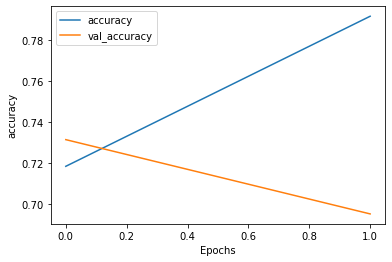

In [53]:
plot_graphs(history, 'accuracy')

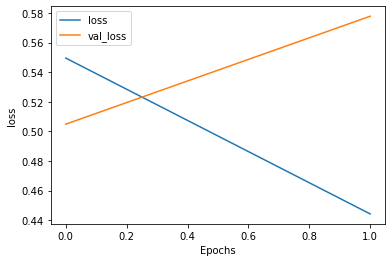

In [54]:
plot_graphs(history, 'loss')

#### ⑥ 데이터 제출하기

In [55]:
## 테스트 데이터 불러오기
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

## 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

## 테스트 데이터 예측하고 저장하기
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv("cnn_predict.csv", index=False, quoting=3)

### 3) MaLSTM 모델
- 순환 신경망 계열의 모델
  - 문장의 시퀀스(Sequence) 형태로 학습시키고 기존 순환 신경망보다 장기적인 학습에 효과적인 성능을 보임
  - MaLSTM 모델은 유사도를 구하기 위해 활용하는 대표적인 모델
  - Manhattan Distance + LSTM (문장 유사도 계산 시, 코사인 유사도가 아닌 맨하탄 거리를 사용)
  
#### ① 모델 구현
- 간단한 모델 생성
  - 단, 순환 신경망 계열 모델의 경우 층이 얕을 경우 성능이 쉽게 높아지지 않음
  - 교재에서는 단층 모델로 확인만 해보기
  

- 하이퍼파라미터 정의

In [58]:
model_name = 'malstm_similarity'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_dimension': 100,
    'lstm_dimension': 150,
}

In [59]:
class MaLSTM(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(MaLSTM, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])
        
    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        x = tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))
        
        return x

In [60]:
model = MaLSTM(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

- Callback 선언

In [61]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./output/quora-question-pairs/malstm_similarity -- Folder create complete 



#### ② 모델 학습

In [62]:
## 40분 가량 소요
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
2100/2100 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.7384
Epoch 00001: val_accuracy improved from -inf to 0.65076, saving model to ./output/quora-question-pairs/malstm_similarity\weights.h5
2100/2100 [==============================] - 611s 291ms/step - loss: 0.5265 - accuracy: 0.7384 - val_loss: 0.6899 - val_accuracy: 0.6508
Epoch 2/5
2100/2100 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8206
Epoch 00002: val_accuracy improved from 0.65076 to 0.76794, saving model to ./output/quora-question-pairs/malstm_similarity\weights.h5
2100/2100 [==============================] - 677s 322ms/step - loss: 0.4015 - accuracy: 0.8206 - val_loss: 0.5144 - val_accuracy: 0.7679
Epoch 3/5
2100/2100 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8470
Epoch 00003: val_accuracy improved from 0.76794 to 0.83214, saving model to ./output/quora-question-pairs/malstm_similarity\weights.h5
2100/2100 [======================

#### ③ 결과 확인

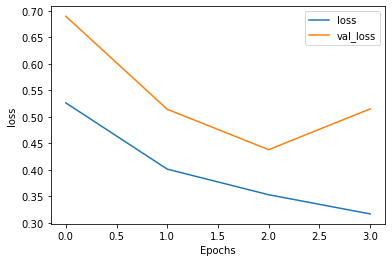

In [63]:
plot_graphs(history, 'loss')

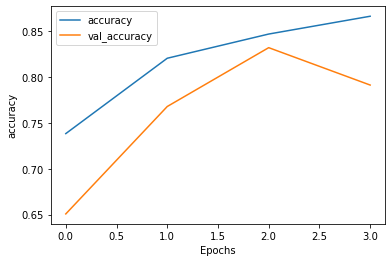

In [64]:
plot_graphs(history, 'accuracy')

#### ④ 데이터 제출하기

In [67]:
## 테스트 데이터 불러오기
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [68]:
## 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [69]:
## 베스트 데이터 예측하기
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv(DATA_OUT_PATH+"rnn_predict.csv", index=False, quoting=3)